In [ ]:
!pip install --upgrade transformers
!pip install nlpaug
!pip install optuna --quiet


# Explanation

## In this project, the dataset was created by scraping quotes, their authors, and their tags from the website quotes.toscrape.com. The target labels are the tags associated with each quote. The goal of the model is to predict the top 3 most relevant tags for a given quote. Accordingly, the accuracy metric was designed to measure how well the model predicts these top 3 tags. The overall aim is to build an automatic tag generation system based on the content of the quote.

#Summary

Due to the small dataset, I first decided to scrape and use all available data.  
Since the tag distribution was imbalanced, I initially changed some tags manually, then applied a clustering model to automate the process.  
As clustering alone was not sufficient, I applied data augmentation to improve model learning.  
Next, I encoded the tag and author information, and combined the author text with the main text input to include it in the model.  
After researching model options, I selected DeBERTa as the most suitable choice for my dataset characteristics.  
Finally, I trained the model using Optuna for hyperparameter tuning.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import csv
import random
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nlpaug.augmenter.word as naw
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch
from torch.utils.data import Dataset
from transformers import (
    DebertaTokenizer,
    DebertaForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
import optuna
from collections import Counter
import unicodedata



# Scrape Data


In [ ]:
url = "https://quotes.toscrape.com"
quotes = []
while url:
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    quote_elements = soup.find_all("div", class_="quote")
    for el in quote_elements:
        text = el.find("span", class_="text").get_text(strip=True)
        author = el.find("small", class_="author").get_text(strip=True)
        tags = [tag.get_text(strip=True) for tag in el.find_all("a", class_="tag")]
        quotes.append({
            "text": text,
            "author": author,
            "tags": ",".join(tags)
        })
    next_btn = soup.find("li", class_="next")
    if next_btn:
        next_link = next_btn.find("a")["href"]
        url = "https://quotes.toscrape.com" + next_link
    else:
        url = None

#save
with open("quotes.csv", "w", newline='', encoding="utf-8") as csvfile:
    fieldnames = ["text", "author", "tags"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for quote in quotes:
        writer.writerow(quote)

# Create Dataframe

In [ ]:
df = pd.DataFrame(quotes)
df.head()

,text,author,tags
0,“The world as we have created it is a process ...,Albert Einstein,"change,deep-thoughts,thinking,world"
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,"abilities,choices"
2,“There are only two ways to live your life. On...,Albert Einstein,"inspirational,life,live,miracle,miracles"
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,"aliteracy,books,classic,humor"
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,"be-yourself,inspirational"


In [ ]:
data = df.copy()
data.isnull().sum()

,0
text,0
author,0
tags,0


In [ ]:
#check for dupl
duplicate_rows = data[data.duplicated()]
duplicate_rows.count()

,0
text,0
author,0
tags,0


# EDA and Cleaning

In [ ]:
all_tags = []
for tags in data['tags']:
    all_tags.extend(tags.split(','))

#Unique tags
unique_tags = set(all_tags)
print(f"{len(unique_tags)} unique tags.")
print("Tags:", unique_tags)

138 unique tags.
Tags: {'', 'poetry', 'fear', 'inspiration', 'sisters', 'unhappy-marriage', 'planning', 'miracles', 'alcohol', 'live-death-love', 'thinking', 'choices', 'faith', 'value', 'good', 'indifference', 'travel', 'adulthood', 'troubles', 'readers', 'food', 'sinister', 'yourself', 'failure', 'attributed-no-source', 'learning', 'lack-of-friendship', 'change', 'dreaming', 'lost', 'writing', 'navigation', 'growing-up', 'marriage', 'fairy-tales', 'happiness', 'elizabeth-bennet', 'misattributed-mark-twain', 'hate', 'sun', 'thought', 'god', 'abilities', 'aliteracy', 'be-yourself', 'hope', 'grown-ups', 'success', 'reading', 'dumbledore', 'world', 'heartbreak', 'the-hunger-games', 'insanity', 'religion', 'miracle', 'wisdom', 'children', 'inspirational', 'quest', 'imagination', 'difficult', 'knowledge', 'connection', 'jane-austen', 'better-life-empathy', 'obvious', 'truth', 'open-mind', 'literature', 'chocolate', 'friendship', 'edison', 'tea', 'bilbo', 'humor', 'activism', 'death', 'lies

In [ ]:
#Clearing
data = data[data['tags'].str.strip() != '']
#Remove tags starting with 'misattributed'
data['tags'] = data['tags'].apply(
    lambda x: ','.join([tag for tag in x.split(',') if not tag.startswith('misattributed')])
)

#Remove rows with empty tags
data = data[data['tags'].str.strip() != '']

/tmp/ipython-input-9-4075481425.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tags'] = data['tags'].apply(


## I will merge authors and text data

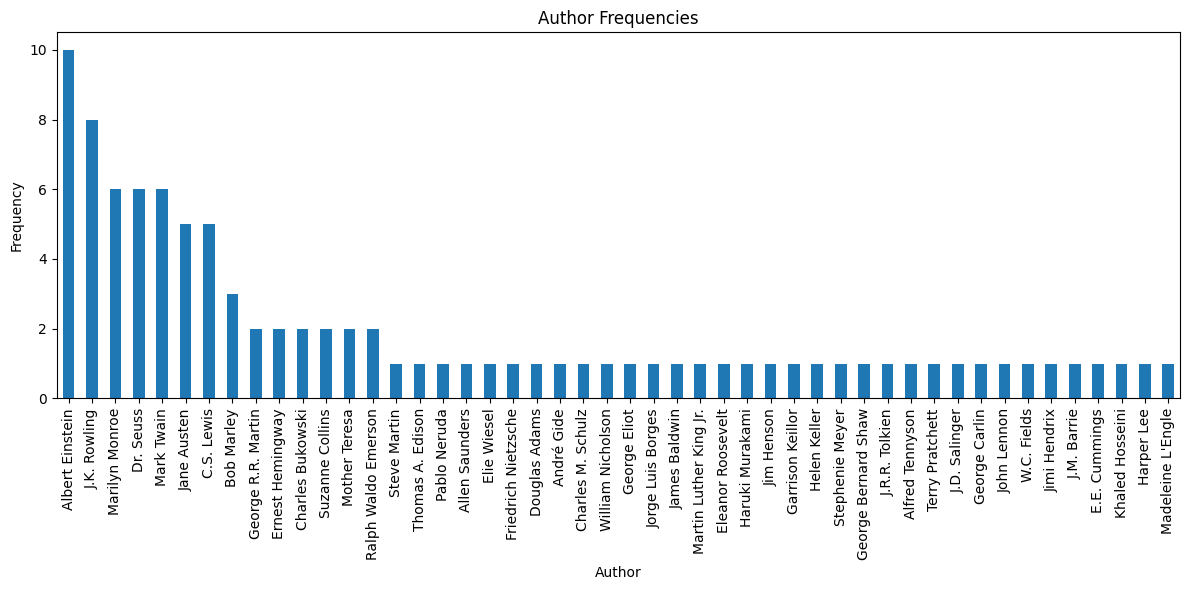

In [ ]:
author_counts = data['author'].value_counts()

plt.figure(figsize=(12, 6))
author_counts.plot(kind='bar')
plt.xlabel('Author')
plt.ylabel('Frequency')
plt.title('Author Frequencies')
plt.tight_layout()
plt.show()

## There are too many low-frequency tags, and there are similar tags among them. I will cluster them based on the similarity of their words.

In [ ]:
all_tags = []
for tags in data['tags']:
    all_tags.extend(tags.split(','))


tag_counts = Counter(all_tags)

#tags frequency
for tag, count in tag_counts.most_common():
    print(f"{tag.strip()}: {count}")

love: 14
inspirational: 13
life: 13
humor: 12
books: 11
reading: 7
friendship: 5
friends: 4
truth: 4
simile: 3
attributed-no-source: 3
death: 3
writing: 3
thinking: 2
classic: 2
paraphrased: 2
courage: 2
philosophy: 2
religion: 2
yourself: 2
children: 2
music: 2
learning: 2
dumbledore: 2
library: 2
hope: 2
change: 1
deep-thoughts: 1
world: 1
abilities: 1
choices: 1
live: 1
miracle: 1
miracles: 1
aliteracy: 1
be-yourself: 1
adulthood: 1
success: 1
value: 1
edison: 1
failure: 1
obvious: 1
heartbreak: 1
sisters: 1
simplicity: 1
understand: 1
fantasy: 1
navigation: 1
activism: 1
apathy: 1
hate: 1
indifference: 1
opposite: 1
lack-of-friendship: 1
lack-of-love: 1
marriage: 1
unhappy-marriage: 1
contentment: 1
fate: 1
planning: 1
plans: 1
poetry: 1
happiness: 1
comedy: 1
fairy-tales: 1
imagination: 1
seuss: 1
chocolate: 1
food: 1
knowledge: 1
understanding: 1
wisdom: 1
read: 1
readers: 1
reading-books: 1
tea: 1
girls: 1
attributed: 1
fear: 1
inspiration: 1
thought: 1
drug: 1
romance: 1
noveli

# Why Agglomerative?
Agglomerative clustering allows us to group tags based on a distance threshold without needing to predefine the number of clusters.

# Why cosine?
Cosine distance is preferred for clustering embeddings because it measures the angle (semantic similarity) between vectors, ignoring their magnitude. This is ideal for NLP embeddings.

In [ ]:
# Get unique tags
all_tags = []
for tags in data['tags']:
    all_tags.extend(tags.split(','))
unique_tags = list(set([t.strip() for t in all_tags if t.strip() != '']))

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(unique_tags)

clustering = AgglomerativeClustering(
    n_clusters=None,
    metric='cosine',
    linkage='average',
    distance_threshold=0.35
)
labels = clustering.fit_predict(embeddings)

tag_to_cluster = {tag: label for tag, label in zip(unique_tags, labels)}

# update Dataframe
def cluster_tags(tag_str):
    tags = [t.strip() for t in tag_str.split(',') if t.strip() != '']
    clusters = [str(tag_to_cluster.get(t, -1)) for t in tags]
    return ','.join(sorted(set(clusters)))

data['tag_clusters'] = data['tags'].apply(cluster_tags)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## This code groups tags into clusters, identifies the most frequent tag in each cluster as a representative, and updates the original tag lists by replacing each tag with its cluster representative, removing duplicates in the process.


In [ ]:
cluster_to_tags = {}
for tag, label in zip(unique_tags, labels):
    cluster_to_tags.setdefault(label, []).append(tag)

#Find the most frequent tag for each cluster
tag_counts = Counter(all_tags)
cluster_representative = {}
for label, tags in cluster_to_tags.items():
    rep = max(tags, key=lambda t: tag_counts[t])
    cluster_representative[label] = rep

def cluster_tags_to_text(tag_str):
    tags = [t.strip() for t in tag_str.split(',') if t.strip() != '']
    clusters = [tag_to_cluster.get(t, -1) for t in tags]
   #Get cluster representatives
    rep_tags = [cluster_representative.get(c, t) for c, t in zip(clusters, tags)]
    #Remove duplicates
    return ','.join(sorted(set(rep_tags)))

data['tags_clustered'] = data['tags'].apply(cluster_tags_to_text)

## As seen in the unique tags below, there are still a large number of low-frequency tags. Therefore, we will apply data augmentation.

In [ ]:
all_clustered_tags = []
for tags in data['tags_clustered']:
    all_clustered_tags.extend([t.strip() for t in tags.split(',') if t.strip() != ''])

clustered_tag_counts = Counter(all_clustered_tags)
for tag, count in clustered_tag_counts.most_common():
    print(f"{tag}: {count}")

inspirational: 14
love: 14
life: 13
humor: 13
books: 12
friendship: 8
reading: 7
thinking: 4
attributed-no-source: 4
truth: 4
adulthood: 3
simile: 3
learning: 3
death: 3
writing: 3
classic: 2
failure: 2
paraphrased: 2
courage: 2
understanding: 2
philosophy: 2
poetry: 2
religion: 2
yourself: 2
children: 2
fairy-tales: 2
music: 2
dumbledore: 2
library: 2
hope: 2
romantic: 2
change: 1
deep-thoughts: 1
world: 1
abilities: 1
choices: 1
miracles: 1
aliteracy: 1
be-yourself: 1
value: 1
edison: 1
obvious: 1
heartbreak: 1
sisters: 1
simplicity: 1
fantasy: 1
navigation: 1
activism: 1
apathy: 1
hate: 1
indifference: 1
opposite: 1
lack-of-friendship: 1
lack-of-love: 1
unhappy-marriage: 1
contentment: 1
fate: 1
planning: 1
happiness: 1
imagination: 1
seuss: 1
chocolate: 1
food: 1
knowledge: 1
wisdom: 1
tea: 1
girls: 1
fear: 1
drug: 1
novelist-quotes: 1
alcohol: 1
the-hunger-games: 1
bilbo: 1
lost: 1
quest: 1
travel: 1
wander: 1
live-death-love: 1
good: 1
regrets: 1
troubles: 1
open-mind: 1
authors:

# TEXT PREPROCCESSING

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

# Augmentation

This script defines text augmenters to increase the number of samples in each tag group to a minimum threshold by generating augmented text samples. It then combines the original and augmented data into a single dataset.

In [ ]:
# Define augmenters
syn_aug = naw.SynonymAug(aug_src='wordnet')
swap_aug = naw.RandomWordAug(action='swap')
del_aug = naw.RandomWordAug(action='delete')
augs = [syn_aug, swap_aug, del_aug]

def augment_text(text, num_aug=1):
    #Augment text num_aug times, skip NotImplementedError
    augmented = []
    for _ in range(num_aug):
        random.shuffle(augs)
        for aug in augs:
            try:
                augmented.append(aug.augment(text))
                break
            except NotImplementedError:
                continue
        else:
            augmented.append(text)
    return augmented

#Augment to reach minimum sample size per tag group
min_samples = 5
augmented_rows = []

for tag, group in data.groupby('tags_clustered'):
    n = len(group)
    if n < min_samples:
        needed = min_samples - n
        for _ in range(needed):
            original = group.sample(1, replace=True).iloc[0]
            aug_txt = augment_text(original['text'], num_aug=1)[0]
            new_row = original.copy()
            new_row['text'] = aug_txt
            augmented_rows.append(new_row)

#Combine original and augmented data
aug_df = pd.DataFrame(augmented_rows)
data = pd.concat([data, aug_df], ignore_index=True)

In [ ]:
all_clustered_tags = []
for tags in data['tags_clustered']:
    all_clustered_tags.extend([t.strip() for t in tags.split(',') if t.strip() != ''])

#we will use this below
clustered_tag_counts = Counter(all_clustered_tags)

To improve model performance and avoid noise, I dropped tags that appeared very infrequently in the dataset.

In [ ]:
to_drop = {tag for tag, count in clustered_tag_counts.items() if count < 5}

def drop_low_freq_tags(tag_str):
    tags = [t.strip() for t in tag_str.split(',') if t.strip() != '']
    filtered = [t for t in tags if t not in to_drop]
    return ','.join(filtered)

data['tags_clustered_filtered'] = data['tags_clustered'].apply(drop_low_freq_tags)
data = data[data['tags_clustered_filtered'].str.strip() != '']
data.head()

,text,author,tags,tag_clusters,tags_clustered,tags_clustered_filtered
0,“The world as we have created it is a process ...,Albert Einstein,"change,deep-thoughts,thinking,world","0,45,79,91","change,deep-thoughts,thinking,world",thinking
2,“There are only two ways to live your life. On...,Albert Einstein,"inspirational,life,live,miracle,miracles","1,21,7","inspirational,life,miracles","inspirational,life"
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,"aliteracy,books,classic,humor","37,47,5,6","aliteracy,books,classic,humor","books,classic,humor"
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,"be-yourself,inspirational","7,84","be-yourself,inspirational",inspirational
5,“Try not to become a man of success. Rather be...,Albert Einstein,"adulthood,success,value","3,67,9","adulthood,failure,value","adulthood,failure"


#Preparing text for our model

## This is the main function that I use in my projects

The `basic_clean` function is a comprehensive text normalization pipeline designed to clean and standardize text data. It performs several key operations:

1. **Lowercasing (optional):** Converts all characters to lowercase to ensure uniformity.
2. **HTML, URL, and Email Removal:** Strips out HTML tags, URLs, and email addresses using pre-compiled regular expressions.
3. **Accent Stripping (optional):** Removes accents from characters, converting them to their base form (e.g., é to e).
4. **Stop-word Removal (optional):** Eliminates common stop words to reduce noise in the text.
5. **Lemmatization (optional):** Converts words to their base or dictionary form, focusing on verbs.
6. **Punctuation Removal (optional):** Deletes punctuation marks to simplify the text.
7. **Number Normalization (optional):** Replaces numbers with a placeholder `<NUM>`.
8. **Whitespace Normalization:** Collapses multiple spaces into a single space and trims leading/trailing spaces.

The function returns the cleaned text as a single space-separated string, making it ready for further processing or analysis.

In [ ]:
# Pre-compile patterns once, reuse inside the function
HTML_TAG_RE   = re.compile(r"<.*?>")                          # remove <tag>
URL_RE        = re.compile(r"https?://\S+|www\.\S+")          # remove http(s):// or www.*
EMAIL_RE      = re.compile(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}")

STOPWORDS   = set(stopwords.words("english"))
LEMMATIZER  = WordNetLemmatizer()

# ---------- helper ----------
def strip_accents(text: str) -> str:
    """Decompose accents (é → e) and drop combining marks."""
    nkfd = unicodedata.normalize("NFKD", text)
    return "".join(c for c in nkfd if not unicodedata.combining(c))

# ---------- main cleaning pipeline ----------
def basic_clean(
    text: str,
    *,
    lowercase: bool = True,
    remove_accents: bool = True,
    remove_stopwords: bool = True,
    normalize_numbers: bool = True,
    lemmatize: bool = True,
    remove_punct: bool = True,
) -> str:
    """
    Basic text‑normalization pipeline
        1. optional lowercase
        2. remove HTML tags, URLs, e‑mails
        3. optional accent stripping
        4. optional stop‑word removal
        5. optional lemmatization (verb form)
        6. collapse multiple spaces
    Returns the cleaned text as a single space‑separated string.
    """


    # --- regex based cleaning ---
    text = HTML_TAG_RE.sub("", text)
    text = URL_RE.sub("", text)
    text = EMAIL_RE.sub("", text)

    if remove_accents:
        text = strip_accents(text)

    if normalize_numbers:                       # <— Number to -> <NUM>
        text = re.sub(r"\d+", "<NUM>", text)

    if remove_punct:
        text = text.translate(str.maketrans('', '', string.punctuation))

    # --- token level operations ---
    tokens = text.split()

    if remove_stopwords:
        tokens = [tok for tok in tokens if tok not in STOPWORDS]

    if lowercase:
        text = text.lower()

    if lemmatize:
        tokens = [LEMMATIZER.lemmatize(tok, "v") for tok in tokens]

    # --- rebuild sentence ---
    cleaned = " ".join(tokens)
    cleaned = re.sub(r"\s+", " ", cleaned).strip()  # final whitespace squeeze
    return cleaned

In [ ]:
import string
#apply to texts

#turn lists to string
def ensure_str(x):
    if isinstance(x, list):
        return x[0]
    return x

data['text'] = data['text'].apply(ensure_str)
data['text']  = data['text'].apply(basic_clean)
data
#check for nulls
data.isnull().sum()

,0
text,0
author,0
tags,0
tag_clusters,0
tags_clustered,0
tags_clustered_filtered,0


## Encoding

One-Hot Encoding: Converts author to binary columns.

Multi-Label Binarization: Transforms tags into a binary matrix.

In [ ]:
#encoding
author_onehot = pd.get_dummies(data['author'], prefix='author')
mlb = MultiLabelBinarizer()
tags_binarized = mlb.fit_transform(data['tags_clustered_filtered'].str.split(','))
tags_binarized_df = pd.DataFrame(tags_binarized, columns=mlb.classes_)

author_onehot.index = data.index
tags_binarized_df.index = data.index


data_encoded = pd.concat([data, author_onehot, tags_binarized_df], axis=1)


In [ ]:

cols_to_drop = ['author', 'tags', 'tag_clusters', 'tags_clustered', 'tags_clustered_filtered']
data_encoded = data_encoded.drop(columns=cols_to_drop)


In [ ]:
data_encoded


,text,author_Albert Einstein,author_Alfred Tennyson,author_Allen Saunders,author_André Gide,author_Bob Marley,author_C.S. Lewis,author_Charles Bukowski,author_Charles M. Schulz,author_Douglas Adams,...,poetry,reading,religion,romantic,simile,thinking,truth,understanding,writing,yourself
0,“The world create process think It cannot chan...,True,False,False,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,0
2,“There two ways live life One though nothing m...,True,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,“The person gentleman lady pleasure good novel...,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,“Imperfection beauty madness genius better abs...,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
5,“Try become man success Rather become man value”,True,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,If “ explain six year old understand ”,True,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,1,0,0
383,“ If explain six old year understand ”,True,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,1,0,0
384,“ If explicate information technology sextuple...,True,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,1,0,0
393,“ Never tell truth mass worthy information tec...,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,1,0,0,0



## Combine quote and author

By combining the quote text with the author information (e.g., "quote text [AUTHOR] author_name"), I provide the model with both the content of the quote and its author as input.

In [ ]:
author_names = data_encoded.filter(like='author_').idxmax(axis=1).str.replace('author_', '')
texts = (data_encoded['text'] + ' [AUTHOR] ' + author_names).tolist()
labels = data_encoded[mlb.classes_].values

# Selecting Model and Tokenization
In this project, I selected **DeBERTa** (*Decoding-enhanced BERT with Disentangled Attention*) as the backbone model for multi-label text classification.


In [ ]:
#tokenize
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
model = DebertaForSequenceClassification.from_pretrained(
    'microsoft/deberta-base',
    num_labels=len(mlb.classes_),
    problem_type='multi_label_classification'
)
token_lengths = [len(tokenizer(text)['input_ids']) for text in data['text']]
print("Max token length:", max(token_lengths))

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Max token length: 130


## Dataset

In [ ]:
class QuotesDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=130):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

# Splitting Data

In [ ]:
print("Data size:", data_encoded.shape)
print("Label columns:", mlb.classes_)


# Split data into training, validation, and test sets
# First, 80% train+val, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.4, random_state=42)

Data size: (315, 76)
Label columns: ['adulthood' 'attributed-no-source' 'books' 'children' 'classic' 'courage'
 'death' 'failure' 'fairy-tales' 'friendship' 'hope' 'humor'
 'inspirational' 'learning' 'library' 'life' 'love' 'paraphrased'
 'philosophy' 'poetry' 'reading' 'religion' 'romantic' 'simile' 'thinking'
 'truth' 'understanding' 'writing' 'yourself']


In [ ]:
train_dataset = QuotesDataset(X_train, y_train, tokenizer)
val_dataset = QuotesDataset(X_val, y_val, tokenizer)
test_dataset = QuotesDataset(X_test, y_test, tokenizer)

In [ ]:
#Compute Metrıcs
def compute_metrics(pred):
    logits = pred.predictions
    labels = pred.label_ids
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    y_pred = (probs > 0.2).astype(int)
    y_true = labels

    # Top-3 confident tag accuracy
    import numpy as np
    top3_pred = np.argsort(probs, axis=1)[:, -3:]
    correct_top3 = []
    for i in range(len(y_true)):
        if any(y_true[i, idx] == 1 for idx in top3_pred[i]):
            correct_top3.append(1)
        else:
            correct_top3.append(0)
    top3_accuracy = sum(correct_top3) / len(correct_top3)

    return {
        "top3_accuracy": top3_accuracy,
        "f1": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
    }

# Training


In [ ]:

#Number of trials to run
N_TRIALS = 5

#Define the hyperparameter search space
def hp_space(trial):
    return {
        "num_train_epochs": trial.suggest_int("num_train_epochs", 7, 15),
        "per_device_train_batch_size": trial.suggest_categorical(
            "per_device_train_batch_size", [2, 4]
        ),
    }

#for each trial, train, evaluate and save only the best model
def objective(trial):
    params = hp_space(trial)

    base_dir = "./models"
    run_dir  = os.path.join(base_dir, f"run_{trial.number}")
    os.makedirs(run_dir, exist_ok=True)

    args = TrainingArguments(
        output_dir=run_dir,
        num_train_epochs=params["num_train_epochs"],
        per_device_train_batch_size=params["per_device_train_batch_size"],
        per_device_eval_batch_size=params["per_device_train_batch_size"],
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_top3_accuracy",
        greater_is_better=True,
        logging_strategy="epoch",
    )

    #fresh model/tokenizer
    model = DebertaForSequenceClassification.from_pretrained(
        "microsoft/deberta-base",
        num_labels=len(mlb.classes_),
        problem_type="multi_label_classification"
    )
    tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Train & evaluate
    trainer.train()
    eval_metrics = trainer.evaluate()

    # At this point trainer.model is the best epoch’s model
    trainer.save_model(run_dir)       # saves only config + best weights
    tokenizer.save_pretrained(run_dir)

    return eval_metrics["eval_top3_accuracy"]


# Create an Optuna study and run the trials
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=N_TRIALS)

# Print the total number of trials
print(f"Total trials: {len(study.trials)}")

# Print each trial’s results
print("\nTrial results:")
print("Trial | Top‑3 Acc | Parameters")
for t in study.trials:
    print(f"{t.number:>2}    | {t.value:.4f}    | {t.params}")

# Print the best trial
best = study.best_trial
print(
    f"\nBest trial: #{best.number} → "
    f"Top‑3 Acc = {best.value:.4f}, Params = {best.params}"
)


[I 2025-07-10 21:49:05,215] A new study created in memory with name: no-name-bedb863b-6543-4461-84fa-d4e5164aa310
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-41-2261819020.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Top3 Accuracy,F1,Precision,Recall
1,0.370900,0.242970,0.564356,0.041522,0.024953,0.126437
2,0.226800,0.223973,0.435644,0.034823,0.074770,0.050485
3,0.216200,0.210695,0.683168,0.093213,0.124713,0.098676
4,0.190400,0.188851,0.722772,0.172265,0.161897,0.197983
5,0.163700,0.164558,0.782178,0.269114,0.309213,0.302299
6,0.137100,0.145422,0.831683,0.340337,0.391036,0.371343
7,0.114100,0.130679,0.881188,0.480196,0.602019,0.514833
8,0.096300,0.115862,0.881188,0.633129,0.793431,0.607745
9,0.081600,0.107357,0.900990,0.696751,0.857539,0.677094
10,0.071600,0.099228,0.930693,0.718256,0.870339,0.670375


[I 2025-07-10 21:55:10,997] Trial 0 finished with value: 0.9306930693069307 and parameters: {'num_train_epochs': 15, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 0.9306930693069307.
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-41-2261819020.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Top3 Accuracy,F1,Precision,Recall
1,0.306700,0.225559,0.564356,0.033609,0.020143,0.103448
2,0.220600,0.223015,0.524752,0.024092,0.074770,0.042371
3,0.206000,0.195229,0.693069,0.123165,0.121597,0.153341
4,0.171700,0.167270,0.782178,0.220727,0.214582,0.249662
5,0.141300,0.143025,0.851485,0.322900,0.364965,0.379646
6,0.112200,0.125561,0.871287,0.433291,0.528901,0.431808
7,0.091400,0.114641,0.910891,0.536826,0.673125,0.522096
8,0.080400,0.105258,0.920792,0.666657,0.801253,0.656719
9,0.073900,0.103213,0.920792,0.677362,0.852400,0.635454


[I 2025-07-10 22:02:05,587] Trial 1 finished with value: 0.9207920792079208 and parameters: {'num_train_epochs': 9, 'per_device_train_batch_size': 2}. Best is trial 0 with value: 0.9306930693069307.
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-41-2261819020.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Top3 Accuracy,F1,Precision,Recall
1,0.310300,0.226287,0.564356,0.023673,0.014339,0.068966
2,0.222600,0.218537,0.524752,0.045376,0.097758,0.058373
3,0.199800,0.182358,0.762376,0.199007,0.182002,0.244377
4,0.159900,0.152907,0.851485,0.187091,0.183559,0.222588
5,0.124300,0.129680,0.871287,0.434723,0.559016,0.440100
6,0.094900,0.105858,0.900990,0.655126,0.769409,0.648837
7,0.075600,0.092456,0.900990,0.667208,0.732073,0.675626
8,0.057400,0.083472,0.910891,0.795597,0.869082,0.783976
9,0.048300,0.073975,0.930693,0.770903,0.837051,0.775274
10,0.039000,0.066555,0.950495,0.859148,0.926213,0.838082


[I 2025-07-10 22:10:09,071] Trial 2 finished with value: 0.9504950495049505 and parameters: {'num_train_epochs': 15, 'per_device_train_batch_size': 2}. Best is trial 2 with value: 0.9504950495049505.
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-41-2261819020.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Top3 Accuracy,F1,Precision,Recall
1,0.306700,0.225559,0.564356,0.033609,0.020143,0.103448
2,0.220600,0.223015,0.524752,0.024092,0.074770,0.042371
3,0.206000,0.195229,0.693069,0.123165,0.121597,0.153341
4,0.171700,0.167270,0.782178,0.220727,0.214582,0.249662
5,0.141300,0.143025,0.851485,0.322900,0.364965,0.379646
6,0.112200,0.125561,0.871287,0.433291,0.528901,0.431808
7,0.091400,0.114641,0.910891,0.536826,0.673125,0.522096
8,0.080400,0.105258,0.920792,0.666657,0.801253,0.656719
9,0.073900,0.103213,0.920792,0.677362,0.852400,0.635454


[I 2025-07-10 22:16:04,755] Trial 3 finished with value: 0.9207920792079208 and parameters: {'num_train_epochs': 9, 'per_device_train_batch_size': 2}. Best is trial 2 with value: 0.9504950495049505.
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-41-2261819020.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Top3 Accuracy,F1,Precision,Recall
1,0.311000,0.226455,0.564356,0.024341,0.014857,0.068966
2,0.222700,0.218478,0.534653,0.041085,0.059991,0.056344
3,0.200100,0.185018,0.752475,0.208615,0.216734,0.244411
4,0.159800,0.152451,0.821782,0.290601,0.335705,0.316520
5,0.126900,0.131376,0.841584,0.415242,0.500924,0.439559
6,0.102900,0.115230,0.881188,0.528625,0.601327,0.554789
7,0.085000,0.108330,0.920792,0.562794,0.528965,0.667802
8,0.075700,0.097049,0.930693,0.703125,0.864173,0.669527
9,0.069800,0.094837,0.940594,0.742449,0.857880,0.713779


[I 2025-07-10 22:21:06,186] Trial 4 finished with value: 0.9405940594059405 and parameters: {'num_train_epochs': 9, 'per_device_train_batch_size': 2}. Best is trial 2 with value: 0.9504950495049505.


Total trials: 5

Trial results:
Trial | Top‑3 Acc | Parameters
 0    | 0.9307    | {'num_train_epochs': 15, 'per_device_train_batch_size': 4}
 1    | 0.9208    | {'num_train_epochs': 9, 'per_device_train_batch_size': 2}
 2    | 0.9505    | {'num_train_epochs': 15, 'per_device_train_batch_size': 2}
 3    | 0.9208    | {'num_train_epochs': 9, 'per_device_train_batch_size': 2}
 4    | 0.9406    | {'num_train_epochs': 9, 'per_device_train_batch_size': 2}

Best trial: #2 → Top‑3 Acc = 0.9505, Params = {'num_train_epochs': 15, 'per_device_train_batch_size': 2}



## At the end of training, all trials are saved in separate folders, allowing each configuration to be preserved.  


In [ ]:
# Print the total number of trials
print(f"Total trials: {len(study.trials)}")

# Print each trial’s results
print("\nTrial results:")
print("Trial | Top‑3 Acc | Parameters")
for t in study.trials:
    print(f"{t.number:>2}    | {t.value:.4f}    | {t.params}")

# Print the best trial
best = study.best_trial
print(
    f"\nBest trial: #{best.number} → "
    f"Top‑3 Acc = {best.value:.4f}, Params = {best.params}"
)

Total trials: 5

Trial results:
Trial | Top‑3 Acc | Parameters
 0    | 0.9307    | {'num_train_epochs': 15, 'per_device_train_batch_size': 4}
 1    | 0.9208    | {'num_train_epochs': 9, 'per_device_train_batch_size': 2}
 2    | 0.9505    | {'num_train_epochs': 15, 'per_device_train_batch_size': 2}
 3    | 0.9208    | {'num_train_epochs': 9, 'per_device_train_batch_size': 2}
 4    | 0.9406    | {'num_train_epochs': 9, 'per_device_train_batch_size': 2}

Best trial: #2 → Top‑3 Acc = 0.9505, Params = {'num_train_epochs': 15, 'per_device_train_batch_size': 2}
